In [1]:
import numpy as np
import os , sys
sys.path.append("..")

In [2]:
from Gen_src.diffusion import GaussianDiffusion1D
from Gen_src.model import Unet1D
import torch
import os,sys
# Add the parent directory of Gen_src to sys.path
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../.."))
import torch
import os

# Same architecture as in training
model = Unet1D(
    dim=32,
    dim_mults=(2, 4, 8, 16),
    channels=2,  # X and Y
    dropout=0.1
).cuda()  # or .to(device)

# Create the same diffusion wrapper
diffusion = GaussianDiffusion1D(
    model,
    seq_length=192,      # must match your training setup
    objective='pred_noise',
    timesteps=1000,
    auto_normalize=False
).cuda()  # or .to(device)

# Load checkpoint
checkpoint_path = rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/diffusion_notebooks/DIffusion_model_weigths_and_datas/model_epoch_499_RMSnorm_unscaled.pt/model_epoch_499_RMSnorm_unscaled.pt"
model.load_state_dict(torch.load(checkpoint_path, weights_only=True))
model.eval()
print("Loaded model weights from:", checkpoint_path)


/home/bardiya/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/optimization_loop/../Gen_src/diffusion.py:331: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @autocast(enabled = False)


Loaded model weights from: /home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/src/diffusion_notebooks/DIffusion_model_weigths_and_datas/model_epoch_499_RMSnorm_unscaled.pt/model_epoch_499_RMSnorm_unscaled.pt


## Data_forming(optional)

In [3]:
# --- Stage-0 : set paths & load raw arrays ----------------------------
from pathlib import Path
import numpy as np

DATA_DIR = Path(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw")          # change here if you move the .npy files

RAW_X_TRAIN = DATA_DIR / "xs_train.npy"
RAW_X_TEST  = DATA_DIR / "xs_test.npy"
RAW_Y_TRAIN = DATA_DIR / "ys_train.npy"
RAW_Y_TEST  = DATA_DIR / "ys_test.npy"

xs_train = np.load(RAW_X_TRAIN)           # (N_train, 192, 2)
xs_test  = np.load(RAW_X_TEST)            # (N_test , 192, 2)
ys_train = np.load(RAW_Y_TRAIN)           # (N_train, 2)  -> [CL, CD]
ys_test  = np.load(RAW_Y_TEST)            # (N_test , 2)

print("Train shapes :", xs_train.shape, ys_train.shape)
print("Test  shapes :", xs_test.shape , ys_test.shape)
# ----------------------------------------------------------------------


Train shapes : (38802, 192, 2) (38802, 2)
Test  shapes : (9701, 192, 2) (9701, 2)


In [4]:
### transform, scale

# ──────────────────────────────────────────────────────────────
#  Toggle here ─ if False you train on raw coordinates/labels.
# ──────────────────────────────────────────────────────────────
APPLY_SCALING = False          # True → min-max scale, False → raw
# ──────────────────────────────────────────────────────────────


# ========== coordinate scaling (Stage-1) ==========
if APPLY_SCALING:
    # compute per-axis min & max on TRAIN only
    x_min, x_max = xs_train[...,0].min(), xs_train[...,0].max()
    y_min, y_max = xs_train[...,1].min(), xs_train[...,1].max()

    xs_train_s = xs_train.copy()
    xs_test_s  = xs_test.copy()

    xs_train_s[...,0] = (xs_train[...,0] - x_min) / (x_max - x_min)
    xs_train_s[...,1] = (xs_train[...,1] - y_min) / (y_max - y_min)

    xs_test_s[...,0]  = (xs_test[...,0]  - x_min) / (x_max - x_min)
    xs_test_s[...,1]  = (xs_test[...,1]  - y_min) / (y_max - y_min)

    coord_mm = np.array([[x_min, y_min], [x_max, y_max]], dtype=np.float32)
else:
    # no scaling – just reuse raw data and write an “identity” scaler
    xs_train_s, xs_test_s = xs_train, xs_test
    coord_mm = np.array([[0., 0.], [1., 1.]], dtype=np.float32)   # inverse() becomes no-op

# save (the filenames never change)
np.save(DATA_DIR / "xs_train_scaled.npy", xs_train_s)
np.save(DATA_DIR / "xs_test_scaled.npy",  xs_test_s)
np.save(DATA_DIR / "coord_min_max.npy",   coord_mm)


# ========== label processing (Stage-2) ==========
if APPLY_SCALING:
    # compute per-axis min & max on TRAIN only
    cl_min, cl_max = ys_train[:,0].min(), ys_train[:,0].max()
    cd_min, cd_max = ys_train[:,1].min(), ys_train[:,1].max()

    ys_train_s = (ys_train - np.array([cl_min, cd_min])) / np.array([cl_max - cl_min, cd_max - cd_min])
    ys_test_s  = (ys_test  - np.array([cl_min, cd_min])) / np.array([cl_max - cl_min, cd_max - cd_min])

    label_mm = np.array([[cl_min, cd_min], [cl_max, cd_max]], dtype=np.float32)
else:
    # no scaling – keep raw CL & CD
    ys_train_s, ys_test_s = ys_train, ys_test
    label_mm = np.array([[0., 0.], [1., 1.]], dtype=np.float32)  # inverse() becomes no-op

np.save(DATA_DIR / "ys_train_scaled.npy", ys_train_s)
np.save(DATA_DIR / "ys_test_scaled.npy",  ys_test_s)
np.save(DATA_DIR / "label_min_max.npy",   label_mm)


# ========== quick sanity print ==========
print(f"APPLY_SCALING = {APPLY_SCALING}")

# coordinate ranges
print("xs_train_scaled X range :", xs_train_s[...,0].min(), xs_train_s[...,0].max())
print("xs_train_scaled Y range :", xs_train_s[...,1].min(), xs_train_s[...,1].max())

# label ranges (CL & CD separately)
print("ys_train_scaled CL range:", ys_train_s[:,0].min(), ys_train_s[:,0].max())
print("ys_train_scaled CD range:", ys_train_s[:,1].min(), ys_train_s[:,1].max())


APPLY_SCALING = False
xs_train_scaled X range : -0.013179942965507507 1.0002249852635365
xs_train_scaled Y range : -0.19444930618259842 0.22336526884723834
ys_train_scaled CL range: -0.2779 1.7515
ys_train_scaled CD range: 0.00232 0.02715


## geting the shapes

In [5]:
from pathlib import Path

DATA_DIR = Path(rf"/home/bardiya/projects/diffusion_air_manifolding/codes/creative-generativeai-diffusion/data/raw")
coord_mm = np.load(DATA_DIR/"coord_min_max.npy")  # [[x_min,y_min],[x_max,y_max]]
x_min,y_min = coord_mm[0]; x_max,y_max = coord_mm[1]

def inv_coords(xs_s):                   # xs_s shape (...,2,192) tensor
    xs_np = xs_s.permute(0,2,1).cpu().numpy()    # -> (B,192,2)
    xs_np[...,0] = xs_np[...,0]*(x_max-x_min) + x_min
    xs_np[...,1] = xs_np[...,1]*(y_max-y_min) + y_min
    return xs_np                                # (B,192,2) numpy


In [6]:
num_to_generate = 128
batch_size      = 128
generated_scaled = []

with torch.no_grad():
    done = 0
    while done < num_to_generate:
        cur = min(batch_size, num_to_generate - done)
        samples_s = diffusion.sample(batch_size = cur)     # (cur,2,192) scaled
        generated_scaled.append(samples_s)
        done += cur
        print(f"Generated {done}/{num_to_generate}")

generated_scaled = torch.cat(generated_scaled, dim=0)      # tensor (9701,2,192)
print("Scaled tensor shape:", generated_scaled.shape)

# ---------- 5) Inverse-scale to physical coords ----------------
generated_real = inv_coords(generated_scaled)               # numpy (9701,192,2)


sampling loop time step:   4%|▎         | 36/1000 [00:08<03:34,  4.49it/s]


KeyboardInterrupt: 

## validating the Generated shapes(optional)

In [15]:
# ================================================================
#  Sanity - pattern and t-SNE on inverse-scaled results
# ================================================================
import numpy as np, matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# -------- helper to draw mean ± std signature -------------------
def plot_signature(xs, name):
    xs = np.asarray(xs)                      # (N,192,2)
    mean_x, std_x = xs[...,0].mean(0), xs[...,0].std(0)
    mean_y, std_y = xs[...,1].mean(0), xs[...,1].std(0)
    fig, ax = plt.subplots(1,2, figsize=(12,3))
    ax[0].plot(mean_x); ax[0].fill_between(range(192), mean_x-std_x, mean_x+std_x, alpha=.2)
    ax[0].set_title(f"{name} X mean±std")
    ax[1].plot(mean_y, color='orange'); ax[1].fill_between(range(192), mean_y-std_y, mean_y+std_y, alpha=.2,color='orange')
    ax[1].set_title(f"{name} Y mean±std")
    plt.tight_layout(); plt.show()
    
# # transpose generated_real to (N,192,2) if not already
# gen_xyz = generated_real                     # (9701,192,2)

# print("=== Point-wise signature comparison ===")
# plot_signature(gen_xyz,           "Generated")
# plot_signature(xs_train,          "Train")
# plot_signature(xs_test,           "Test")

# # # -------- t-SNE settings ----------------------------------------
# USE_TRAIN_AS_REAL = False          # set True to compare with train set

# real_set   = xs_train if USE_TRAIN_AS_REAL else xs_test
# real_label = "Train" if USE_TRAIN_AS_REAL else "Test"


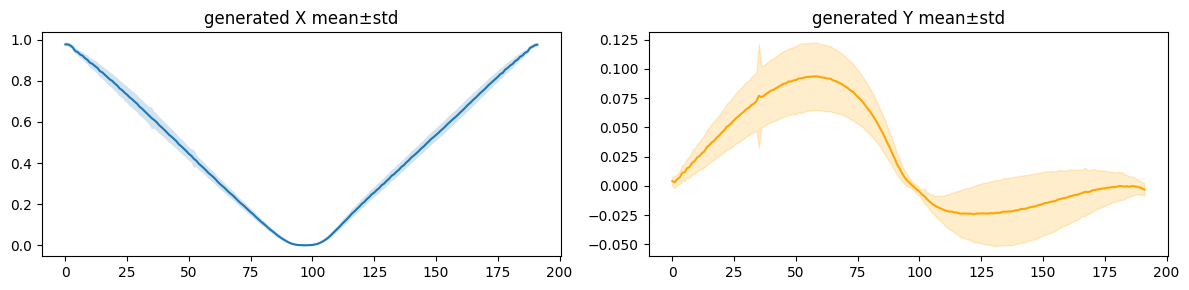

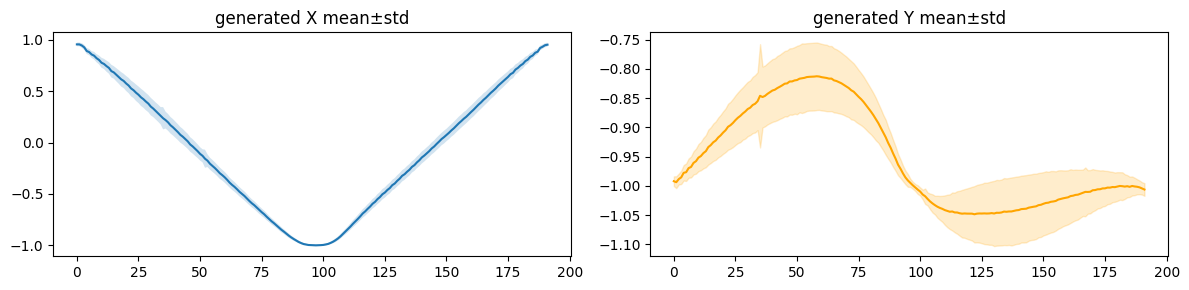

In [16]:
plot_signature(generated_real , "generated")
plot_signature(generated_scaled.transpose(1,2).cpu().detach().numpy() * 2 -1, "generated")
# torch.equal(generated_scaled.transpose(1,2) ,  generated_scaled.permute(0,2,1))
# torch.equal(generated_scaled.transpose(1,2).cpu() ,  torch.tensor(generated_real))

## getting the same shape for specific latent(optional)

In [10]:
latent = torch.randn((1,2,192)).to("cuda")
samples1 = diffusion.latent_sample(latent , is_ddim=True)
samples2 = diffusion.latent_sample(latent , is_ddim=True)
generated_samples1 = inv_coords(samples1)
generated_samples2 = inv_coords(samples2)

sampling loop time step: 100%|██████████| 1000/1000 [00:22<00:00, 43.53it/s]


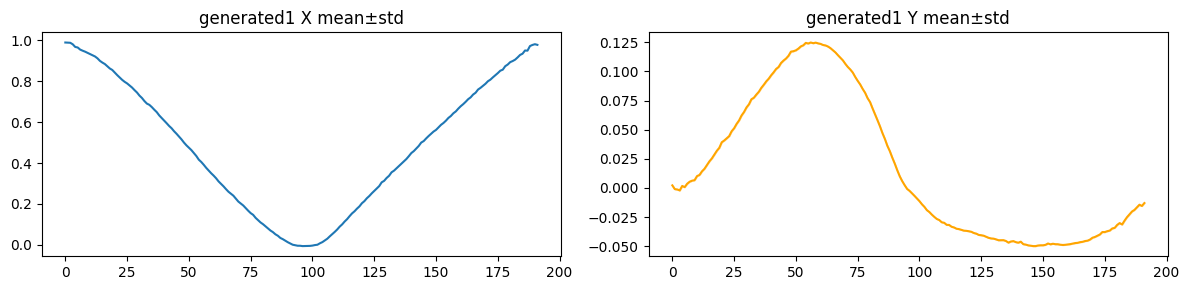

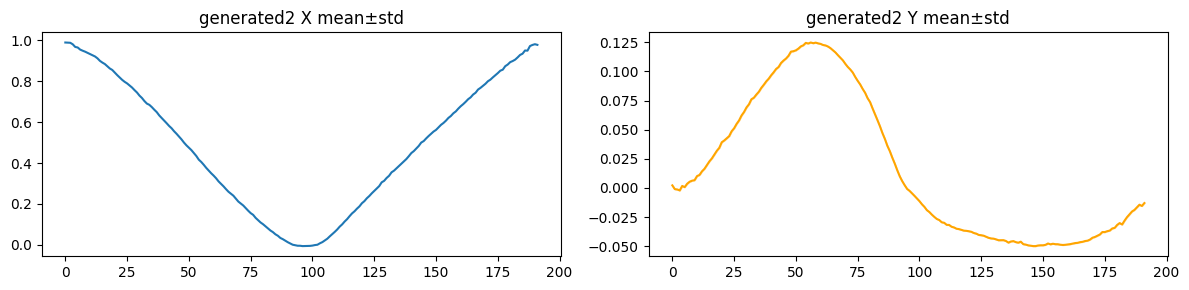

In [11]:
plot_signature(generated_samples1, "generated1")
plot_signature(generated_samples2, "generated2")

In [13]:
np.array_equal(generated_samples1 , generated_samples2)

True